# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [153]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [154]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [155]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-21 09:00:00+09:00,49675.429688,49739.761719,49447.691406,49531.828125,0,0.0,0.0
2025-10-21 09:15:00+09:00,49532.929688,49707.550781,49532.929688,49667.101562,0,0.0,0.0
2025-10-21 09:30:00+09:00,49664.910156,49736.660156,49575.011719,49723.988281,0,0.0,0.0
2025-10-21 09:45:00+09:00,49723.550781,49794.898438,49683.628906,49785.648438,0,0.0,0.0
2025-10-21 10:00:00+09:00,49787.941406,49851.871094,49704.820312,49704.820312,0,0.0,0.0
2025-10-21 10:15:00+09:00,49706.019531,49804.679688,49706.019531,49791.128906,0,0.0,0.0
2025-10-21 10:30:00+09:00,49792.031250,49884.261719,49781.679688,49882.000000,0,0.0,0.0
2025-10-21 10:45:00+09:00,49884.109375,49912.230469,49857.679688,49870.300781,0,0.0,0.0
2025-10-21 11:00:00+09:00,49870.921875,49899.921875,49870.921875,49893.281250,0,0.0,0.0


## 前日終値の取得

In [156]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-14 00:00:00+09:00    46847.320312
2025-10-15 00:00:00+09:00    47672.671875
2025-10-16 00:00:00+09:00    48277.738281
2025-10-17 00:00:00+09:00    47582.148438
2025-10-20 00:00:00+09:00    49185.500000
2025-10-21 00:00:00+09:00    49893.281250
Name: Close, dtype: float64


Date
2025-10-20 00:00:00+09:00    49185.5
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [157]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+489.93


## ローソク足チャート（小さいサイズ）

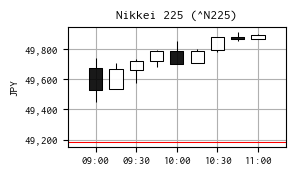

In [158]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [159]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [160]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-20 08:00:00+09:00,150.822998,150.940002,150.815002,150.927994,0,0.0,0.0
2025-10-20 08:15:00+09:00,150.929993,150.964996,150.813995,150.832993,0,0.0,0.0
2025-10-20 08:30:00+09:00,150.835007,150.912003,150.820999,150.848999,0,0.0,0.0
2025-10-20 08:45:00+09:00,150.839996,150.938995,150.798004,150.917007,0,0.0,0.0
2025-10-20 09:00:00+09:00,150.912994,150.975006,150.811005,150.882004,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-21 10:15:00+09:00,150.636002,150.738007,150.567001,150.731995,0,0.0,0.0
2025-10-21 10:30:00+09:00,150.733002,150.897995,150.671005,150.873993,0,0.0,0.0
2025-10-21 10:45:00+09:00,150.880997,150.994003,150.850998,150.975006,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [161]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-21 09:00:00+09:00,329.850117,330.277289,328.337911,328.896588
2025-10-21 09:15:00+09:00,328.727111,329.885990,328.727111,329.617547
2025-10-21 09:30:00+09:00,329.878865,330.355435,329.281752,330.271268
2025-10-21 09:45:00+09:00,330.051300,330.524886,329.786309,330.463487
2025-10-21 10:00:00+09:00,330.526981,330.951390,329.975165,329.975165
2025-10-21 10:15:00+09:00,329.764226,330.418766,329.764226,330.328866
2025-10-21 10:30:00+09:00,330.023951,330.635259,329.955340,330.620268
2025-10-21 10:45:00+09:00,330.413031,330.599294,330.237971,330.321568
2025-10-21 11:00:00+09:00,330.290698,330.482762,330.290698,330.438782


### 前日の終値のドル円レートから、前日の終値のドル換算

In [162]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-20 15:15:00+09:00


np.float64(150.6540069580078)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 326.4798659733598


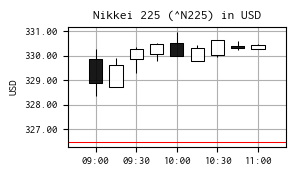

In [163]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()